# Part 7: Тестируем варианты головной сети и размеры изображения
- Тестируем различное количество слоев и нейронов в головной сети.
- Тестируем различные размеры изображения.

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf

config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.19.4
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!pip freeze > requirements.txt

## Основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS = 10  # эпох на обучение
BATCH_SIZE = 64  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR = 0.001 # lerning rate
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE1 = 224  # какого размера подаем изображения в сеть
IMG_SIZE2 = 298  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE1, IMG_SIZE2, IMG_CHANNELS)

part = 'part_7'  # Версия эксперимента

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

### Необходимые функции

In [7]:
# Графики
def make_graf(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [8]:
# Тест модели
def start_learning(num_epochs):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=test_generator,
        validation_steps=len(test_generator),
        epochs=num_epochs,
        callbacks=callbacks_list
    )

    return history

## EDA / Анализ данных

In [9]:
train_df = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [11]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [12]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile("data/"+data_zip, "r") as z:
#         z.extractall('data/')

# print(os.listdir('data/'))

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

Пример картинок (random sample)


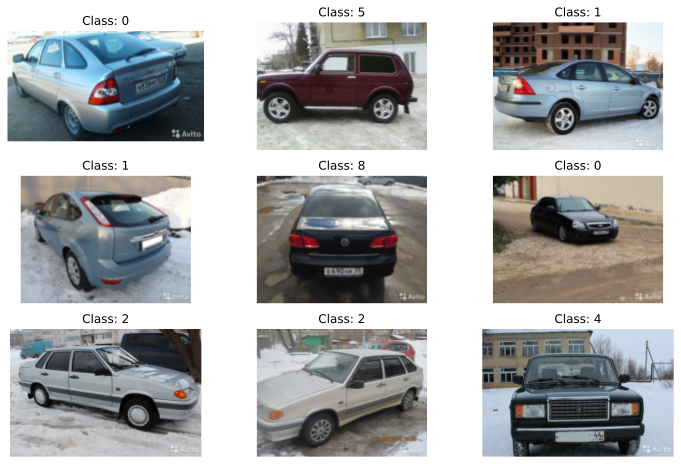

In [13]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'data/train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')

plt.show()

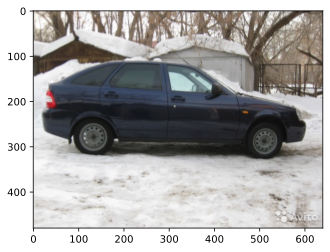

(640, 480)

In [14]:
image = PIL.Image.open('data/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
### Аугментация данных

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=VAL_SPLIT,  # set validation split
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1],
    zoom_range=0.1,
    channel_shift_range=1.0)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [16]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим результат

Пример картинок из train_generator


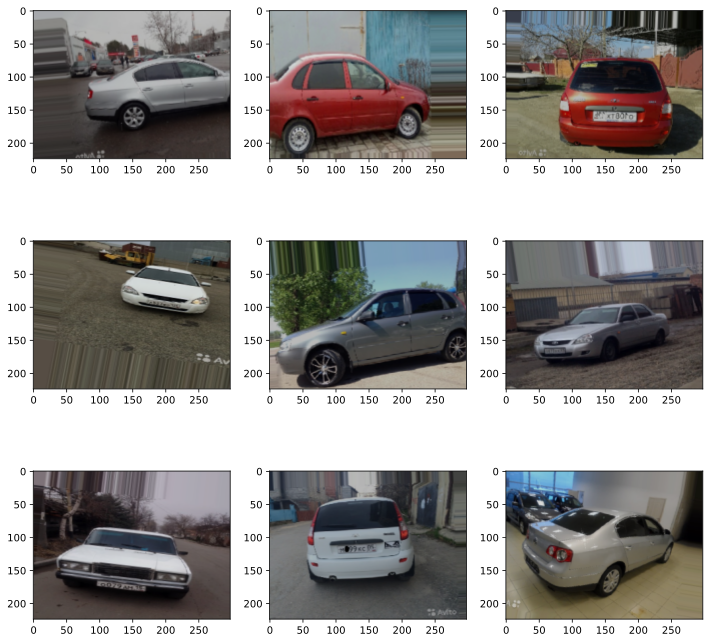

In [17]:
from skimage import io
 
def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()
 
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,12))
 
for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели
### Загружаем предобученную сеть Xception

In [18]:
base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)

Замораживаем веса

In [19]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

Строим модель

In [20]:
# Устанавливаем новую "голову" (head)
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучение модели
Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [21]:
checkpoint = ModelCheckpoint('best_model_{}.h5'.format(
    part), monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Обучаем

In [22]:
history = start_learning(5)

Epoch 1/5
207/207 [==============================] - 348s 2s/step - loss: 1.7158 - accuracy: 0.3698 - val_loss: 1.2101 - val_accuracy: 0.5715

Epoch 00001: saving model to best_model_part_7.h5
Epoch 2/5
207/207 [==============================] - 348s 2s/step - loss: 1.2308 - accuracy: 0.5556 - val_loss: 1.1087 - val_accuracy: 0.6063

Epoch 00002: saving model to best_model_part_7.h5
Epoch 3/5
207/207 [==============================] - 351s 2s/step - loss: 1.0960 - accuracy: 0.6118 - val_loss: 1.0669 - val_accuracy: 0.6183

Epoch 00003: saving model to best_model_part_7.h5
Epoch 4/5
207/207 [==============================] - 395s 2s/step - loss: 1.0399 - accuracy: 0.6237 - val_loss: 1.0301 - val_accuracy: 0.6191

Epoch 00004: saving model to best_model_part_7.h5
Epoch 5/5
207/207 [==============================] - 417s 2s/step - loss: 1.0001 - accuracy: 0.6376 - val_loss: 1.0096 - val_accuracy: 0.6372

Epoch 00005: saving model to best_model_part_7.h5


In [23]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.h5'.format(part))

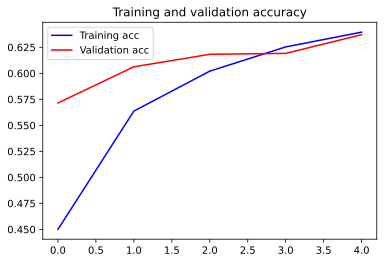

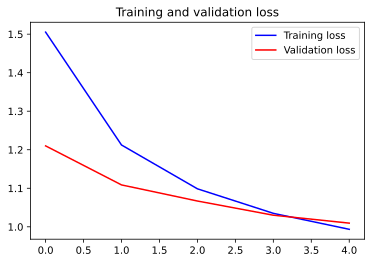

In [24]:
# Графики
make_graf(history)

### Step 2

In [22]:
from tensorflow.keras.models import load_model
model = load_model('model_last_part_7.h5')
model.load_weights('best_model_part_7.h5')

Посмотрим сколько слоев в имиджнет модели

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


Размораживаем имиджнет-модель частично

In [24]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 106

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Обучаем

In [26]:
history = start_learning(5)

Epoch 1/5
207/207 [==============================] - 360s 2s/step - loss: 0.9905 - accuracy: 0.6380 - val_loss: 0.9605 - val_accuracy: 0.6565

Epoch 00001: saving model to best_model_part_7.h5
Epoch 2/5
207/207 [==============================] - 353s 2s/step - loss: 0.9229 - accuracy: 0.6625 - val_loss: 0.9314 - val_accuracy: 0.6694

Epoch 00002: saving model to best_model_part_7.h5
Epoch 3/5
207/207 [==============================] - 345s 2s/step - loss: 0.9033 - accuracy: 0.6747 - val_loss: 0.9495 - val_accuracy: 0.6578

Epoch 00003: saving model to best_model_part_7.h5
Epoch 4/5
207/207 [==============================] - 344s 2s/step - loss: 0.8707 - accuracy: 0.6906 - val_loss: 0.8909 - val_accuracy: 0.6750

Epoch 00004: saving model to best_model_part_7.h5
Epoch 5/5
207/207 [==============================] - 344s 2s/step - loss: 0.8594 - accuracy: 0.6845 - val_loss: 0.9245 - val_accuracy: 0.6617

Epoch 00005: saving model to best_model_part_7.h5


In [27]:
import telegram
import yaml

# Импортируем токен
with open(r'C:\Users\niam1\OneDrive\Documents\5-Programing\Files\config_telegram_niki_tech_bot.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
token = config['bot_token']

# Создаем объект для работы с ботом
bot = telegram.Bot( token )

# Send message
bot.sendMessage(chat_id = 568131606, text = f'{part} - расчет окончен!')

In [28]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.h5'.format(part))

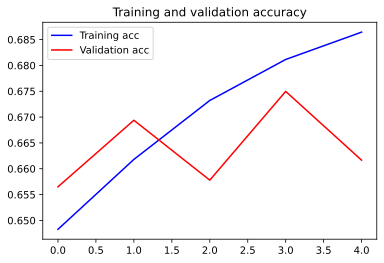

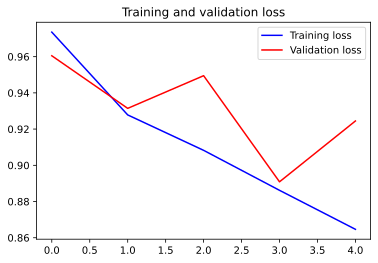

In [29]:
# Графики
make_graf(history)

### Step 3

In [22]:
from tensorflow.keras.models import load_model
model = load_model('model_last_part_7.h5')
model.load_weights('best_model_part_7.h5')

Размораживаем имиджнет-модель частично

In [23]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 76

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Уменьшаем learning rate

In [24]:
LR=0.0005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Обучаем

In [25]:
history = start_learning(5)

Epoch 1/5
207/207 [==============================] - 352s 2s/step - loss: 0.8100 - accuracy: 0.7058 - val_loss: 0.8441 - val_accuracy: 0.6969

Epoch 00001: saving model to best_model_part_7.h5
Epoch 2/5
207/207 [==============================] - 349s 2s/step - loss: 0.7863 - accuracy: 0.7149 - val_loss: 0.8547 - val_accuracy: 0.6900

Epoch 00002: saving model to best_model_part_7.h5
Epoch 3/5
207/207 [==============================] - 389s 2s/step - loss: 0.7626 - accuracy: 0.7300 - val_loss: 0.8642 - val_accuracy: 0.6827

Epoch 00003: saving model to best_model_part_7.h5
Epoch 4/5
207/207 [==============================] - 374s 2s/step - loss: 0.7570 - accuracy: 0.7263 - val_loss: 0.8278 - val_accuracy: 0.6926

Epoch 00004: saving model to best_model_part_7.h5
Epoch 5/5
207/207 [==============================] - 356s 2s/step - loss: 0.7549 - accuracy: 0.7323 - val_loss: 0.8283 - val_accuracy: 0.7110

Epoch 00005: saving model to best_model_part_7.h5


In [26]:
import telegram
import yaml

# Импортируем токен
with open(r'C:\Users\niam1\OneDrive\Documents\5-Programing\Files\config_telegram_niki_tech_bot.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
token = config['bot_token']

# Создаем объект для работы с ботом
bot = telegram.Bot( token )

# Send message
bot.sendMessage(chat_id = 568131606, text = f'{part} - расчет окончен!')

In [27]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.h5'.format(part))

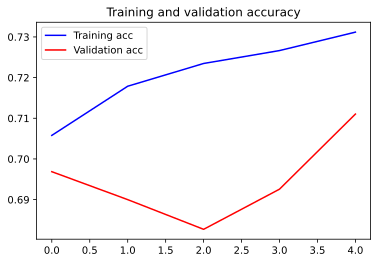

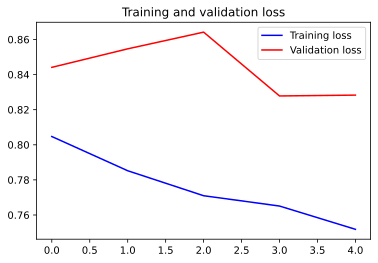

In [28]:
# Графики
make_graf(history)

### Step 4

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_last_part_7.h5')
model.load_weights('best_model_part_7.h5')

Размораживаем имиджнет-модель частично

In [29]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 46

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [30]:
LR=0.0005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Обучаем

In [32]:
history = start_learning(5)

Epoch 1/5
207/207 [==============================] - 363s 2s/step - loss: 0.7541 - accuracy: 0.7271 - val_loss: 0.8235 - val_accuracy: 0.6964

Epoch 00001: saving model to best_model_part_7.h5
Epoch 2/5
  8/207 [>.............................] - ETA: 4:57 - loss: 0.6597 - accuracy: 0.7622

KeyboardInterrupt: 

In [ ]:
import telegram
import yaml

# Импортируем токен
with open(r'C:\Users\niam1\OneDrive\Documents\5-Programing\Files\config_telegram_niki_tech_bot.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
token = config['bot_token']

# Создаем объект для работы с ботом
bot = telegram.Bot( token )

# Send message
bot.sendMessage(chat_id = 568131606, text = f'{part} - расчет окончен!')

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.h5'.format(part))

In [ ]:
# Графики
make_graf(history)

### Step 5

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_last_part_7.h5')
model.load_weights('best_model_part_7.h5')

Окончательно размораживаем имиджнет-модель

In [ ]:
base_model.trainable = True

Еще уменьшаем learning rate

In [ ]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Обучаем

In [ ]:
history = start_learning(5)

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

In [ ]:
# Графики
make_graf(history)

### Оценим метрику

In [ ]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

## Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

In [ ]:
submission.head()

### Вывод по данной части работы:
- Метрика на тесте: %
- Метрика на Kaggle: %

**Предварительные выводы:**
- Увеличение размера изображения увеличивает время обучения сети, однако приводит к улучшению точности до определенного предела.
- Размер изображений и их пропорция подобрана исходя из оптимального соотношения время расчета / точность результата.
- Увеличение слоев головной сети также дает положительное влияние на точность предсказаний только до определенного уровня и также замедляет обучение модели.
- Оставлено 2 полносвязных слоя перед выходным слоем c dropout нормализацией.